In [1]:
from __future__ import print_function
from f4klib2 import *
import seaborn as sns
movs = loadMovids()
movs_length = loadLengths()

def getTrainingResult():
    
    
    idl = np.hstack((np.arange(30598,30633),np.arange(30634,30638)))
    
    forty = np.array([112,180,272,285,330,       447,469,474,498,500,
                      517,527,545,550,622,       661,713,720,749,771,
                      779,806,807,902,959,       970,982,1038,1042,1068,
                      1085,1100,1111,1114,1116,  1136,1147,1155,1211,1258,
                      1306,1373,1379,1409,1432,  1505])
    fortyone = np.array([10,33,75,82,101,           114,182,183,275,279,
                         282,291,306,325,338,       380,420,424,449,482,
                        490,518,560,579,593,        616,652,657,685,695,
                        701,737,740,793,803,        811,834,843,844,858,
                        868,923,931,955,966,        1029,1030,1156,1160,1187, 
                        1193,1223,1241,1278,1279,   1281,1323,1356,1361,1366,
                        1378,1413,1428,1491,1493,   1513,1530,1535])

    idl = np.hstack((idl,forty,fortyone))
        
    location = "/afs/inf.ed.ac.uk/group/project/F4KC/output/{0}/{1}/{2}.YHAT.npy"
    start = True

    for i in idl:
        idee = movs[i][0]
        length = movs_length[i]
        yhat = np.load(location.format(idee[0],idee[0:2],idee))
        
        try:
            gts = loadGT(idee, movs_length[i], partial=True)
        except:
            try:
                gts = loadGT(idee, movs_length[i], partial=False)
            except:
                gts = loadNewGT(idee, movs_length[i])
        gts = np.array(gts)
        mask = gts != None
        yhat = yhat[mask]
        gts = gts[mask]

        if start:
            yhats = yhat
            targets = gts
            start = False
        else:
            yhats = np.vstack((yhats,yhat))
            targets = np.hstack((targets,gts))

    mask = targets != 0
    yhats = yhats[mask]
    targets = targets[mask]

    #yhats = yhats.reshape(-1,40)
    targets = targets.astype(int)

    return (yhats,targets)

def getValidationResult(split = None):
    
    idl = np.array([396853,396857,396859,396860,396866,396876,396880,396892,396895,396900,
                    396823,396829,396843,396852,396862,396870,396882,396885,396889,396894,
                    396856,396863,396864,396868,396869,396893,396896,396897,396898,396899,
                    396624,396639,396662,396675,396728,396737,396759,396777,396790,396804,
                    396750,396760,396767,396784,396792,396793,396872,396877,396878,396886,
                    396824,396836,396839,396854,396858,396861,396865,396871,396874,396884,
                    396720,396733,396778,396815,396820,396827,396830,396834,396879,396890,
                    396840,396841,396845,396849,396850,396851,396867,396883,396887,396891,
                    396785,396802,396811,396822,396838,396844,396873,396875,396881,396888])

    if split != None:
        idl = idl.reshape(-1,2)[:,split-1]
        
    location = "/afs/inf.ed.ac.uk/group/project/F4KC/output/{0}/{1}/{2}.YHAT.npy"
    start = True

    for i in idl:
        idee = movs[i][0]
        length = movs_length[i]
        spacing = 1
        if length >= 200:
            spacing = length/100
        yhat = np.load(location.format(idee[0],idee[0:2],idee))
        gts = loadNewGT(idee, movs_length[i],validation=True,spacing=spacing)
        gts = np.array(gts)
        mask = gts != None
        yhat = yhat[mask]
        gts = gts[mask]

        if start:
            yhats = yhat
            targets = gts
            start = False
        else:
            yhats = np.vstack((yhats,yhat))
            targets = np.hstack((targets,gts))

    mask = targets != 0
    yhats = yhats[mask]
    targets = targets[mask]

    #yhats = yhats.reshape(-1,40)
    targets = targets.astype(int)

    return (yhats,targets)

def getWeightedVote(vec,keptRange,lim=0.5):
    return np.sum(vec[np.array(keptRange)-1])>=lim

def vote(yhats,targets,svm=True,cnn=True,cnnwc=True,cnnbc=True,minvote=1,keptRange=[6,7,8],lim=0.5, ret=False):
    
    l = len(targets)
    #result = np.argmax(yhats,2) + 1
    
    binary = [False] * l
    summu = np.sum(yhats,1)[:,6]>=3.999
    summu2 = np.sum(yhats,1)[:,1]>=3.999
    for i in range(l):
        #FEIF
        if summu[i] or summu2[i]:
            continue
            
        count = 0
        #if svm   and (result[i,0] in keptRange): count+=1
        #if cnn   and (result[i,1] in keptRange): count+=1
        #if cnnwc and (result[i,2] in keptRange): count+=1
        #if cnnbc and (result[i,3] in keptRange): count+=1
        if svm   and getWeightedVote(yhats[i,0,:],keptRange=keptRange,lim=lim): count+=1
        if cnn   and getWeightedVote(yhats[i,1,:],keptRange=keptRange,lim=lim): count+=1
        if cnnwc and getWeightedVote(yhats[i,2,:],keptRange=keptRange,lim=lim): count+=1
        if cnnbc and getWeightedVote(yhats[i,3,:],keptRange=keptRange,lim=lim): count+=1
        if count >= minvote:
            binary[i] = True
    
    string = "Using classifiers: "
    classifiers = ""
    if svm:  classifiers+="SVM "
    else:    classifiers+="    "
    if cnn:  classifiers+="CNN "
    else:    classifiers+="    "
    if cnnwc:classifiers+="CNN_WC "
    else:    classifiers+="       "
    if cnnbc:classifiers+="CNN_BC "
    else:    classifiers+="       "
    string += classifiers
    string += "; Minimum vote needed: {0}".format(minvote)
    
    if not ret:
    
        print(string)
        print()
    
    #Transform the result to fit old util
    fakeyhat = np.array([1] * l)
    fakeyhat[binary] = 6
    
    #Feed the result to old function
    #Change grange here
    tp,fn,fp,tn = validateResult(fakeyhat,targets,grange=[6,8],succint=True,value=True,ret=ret)
    
    if ret:
        return (tp,fn,fp,tn)

In [2]:
summ = 0
for index, mov in enumerate(movs):
    if int(mov[0][-12:-4]) > 20110805 and (int(mov[1])<= 39 or mov[1]=="42") and mov[2]=="1": 
        summ += movs_length[index]
print(summ)
print(summ*1.0/sum(movs_length))

324530231
0.38659134561145686


In [156]:
summ = 0
for index, mov in enumerate(movs):
    hour = int(mov[0][-4:-2])
    if (hour == 6) and (mov[1]=="44" or mov[1]=="46"): 
        summ += movs_length[index]
print(summ)
print(summ*1.0/sum(movs_length))

1626357
0.0019373712554828586


In [6]:
yhats, targets = getValidationResult(split=None)
print(vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=False,minvote=0,keptRange=[6],lim=0, ret=True))

yhats, targets = getValidationResult(split=None)
print(vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,keptRange=[6],lim=0.0729, ret=True))

(3060.0, 152.0, 3303.0, 1440.0)


In [2]:
yhats, targets = getTrainingResult()

In [86]:
print(vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=False,minvote=0,keptRange=[6],lim=0, ret=True))
print(vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,keptRange=[6],lim=0.0729, ret=True))

(26702.0, 3948.0, 27201.0, 12532.0)
(26211.0, 4439.0, 19511.0, 20222.0)


In [ ]:
Training set:
                | rejected by FEIF | remaining rejected by SVM | remaining fish
True Fish       | 3948             | 491                       | 26211
Bad or non-fish | 12532            | 7690                      | 19511

Validation set:
                | rejected by FEIF | remaining rejected by SVM | remaining fish
True Fish       | 152              | 88                        | 2972
Bad or non-fish | 1440             | 553                       | 2750

In [77]:
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,keptRange=[6,8],lim=0.0729, ret=False)

Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2972; Lost: 149 ;
None Fish Kept: 2750; Lost: 819 ;
Accuracy: 0.566666666667


In [5]:
roc = np.zeros((36,2,101))
counta = 0
time = datetime.now()
for svm in [True,False]:
    for cnnwc in [True,False]:
        for cnnbc in [True,False]:
            count = 0
            if svm   : count+=1
            if cnnwc : count+=1
            if cnnbc : count+=1
            if count == 0:continue
            for i in np.arange(1,count+1):
                for kept in [[6,7,8],[6,8],[6]]:
                    for j in range(101):
                        tp,fn,fp,tn = vote(yhats,targets,svm=svm,cnn=False,cnnwc=cnnwc,cnnbc=cnnbc,minvote=i,keptRange=kept,lim=(j*0.01),ret=True)
                        roc[counta,0,j] = tp * 1.0 / (tp + fn)
                        roc[counta,1,j] = fp * 1.0 / (fp + tn)
                        print("{0} {1} {2}".format(counta,j,datetime.now()-time),end='\r')
                    counta += 1

In [9]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")

In [10]:
countt = 0
for svm in [True,False]:
    for cnnwc in [True,False]:
        for cnnbc in [True,False]:
            count = 0
            if svm   : count+=1
            if cnnwc : count+=1
            if cnnbc : count+=1
            if count == 0:continue
            for i in np.arange(1,count+1):
                print("{4}: SVM:{0},CNNWC:{1},CNNBC:{2},VOTE:{3}".format(svm,cnnwc,cnnbc,i,countt))
                countt += 1

0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1


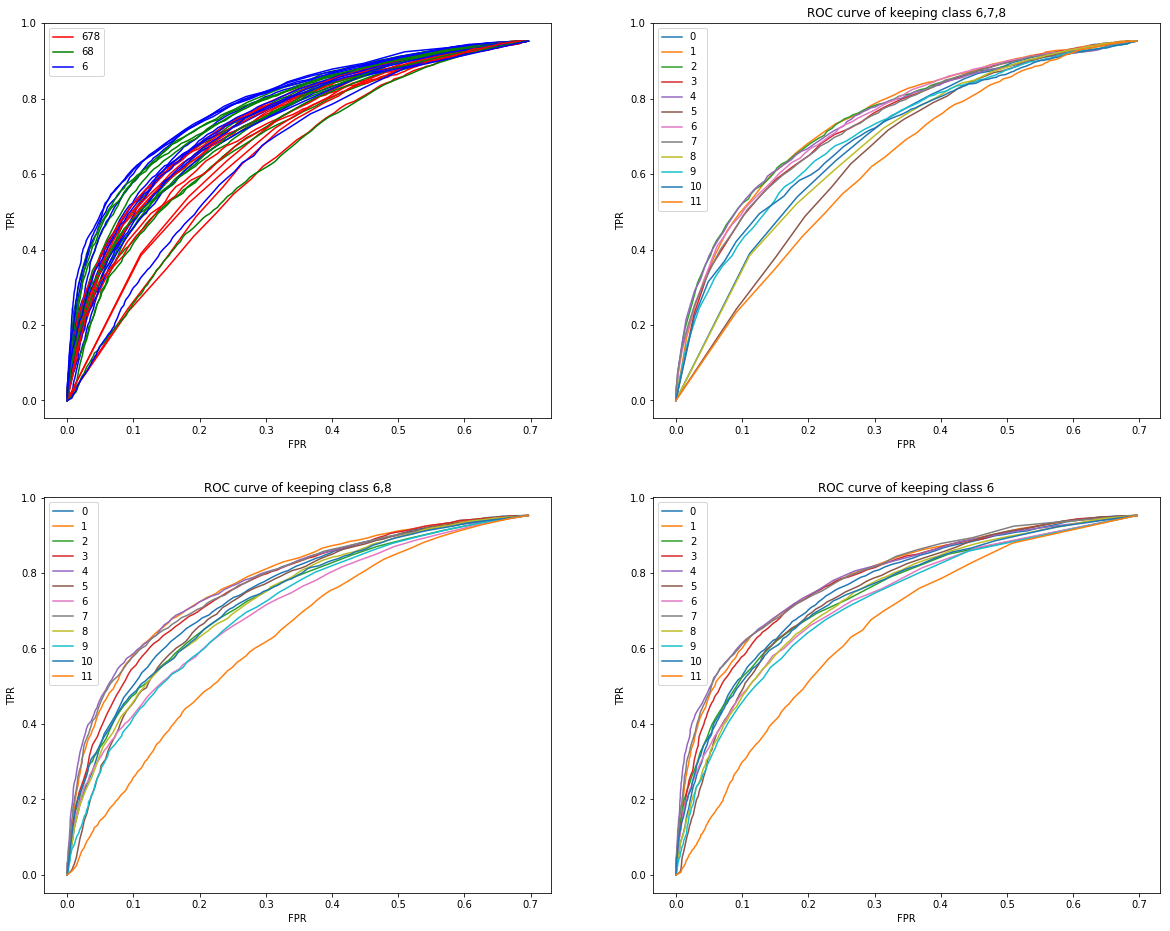


0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1



In [6]:
plt.subplots(2,2,figsize=(20,16))

plt.subplot(221)
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],"b")
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],"g")
    if i%3 == 0:
        plt.plot(roc[i,1,:],roc[i,0,:],"r")
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
plt.legend(["678","68","6"])
#plt.show()

plt.subplot(222)
for i in range(36):
    if i%3 == 0:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6,7,8")
plt.legend(np.arange(36))
#plt.show()

plt.subplot(223)
for i in range(36):
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6,8")
plt.legend(np.arange(36))
#plt.show()

plt.subplot(224)
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6")
plt.legend(np.arange(36))

plt.show()
print("""
0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1
""")

In [99]:
tp,fn,fp,tn = vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=False,minvote=0,keptRange=[6,8],lim=0,ret=True)
print(tp)
print(fn)
print(fp)
print(tn)

2928.0
284.0
3621.0
1122.0


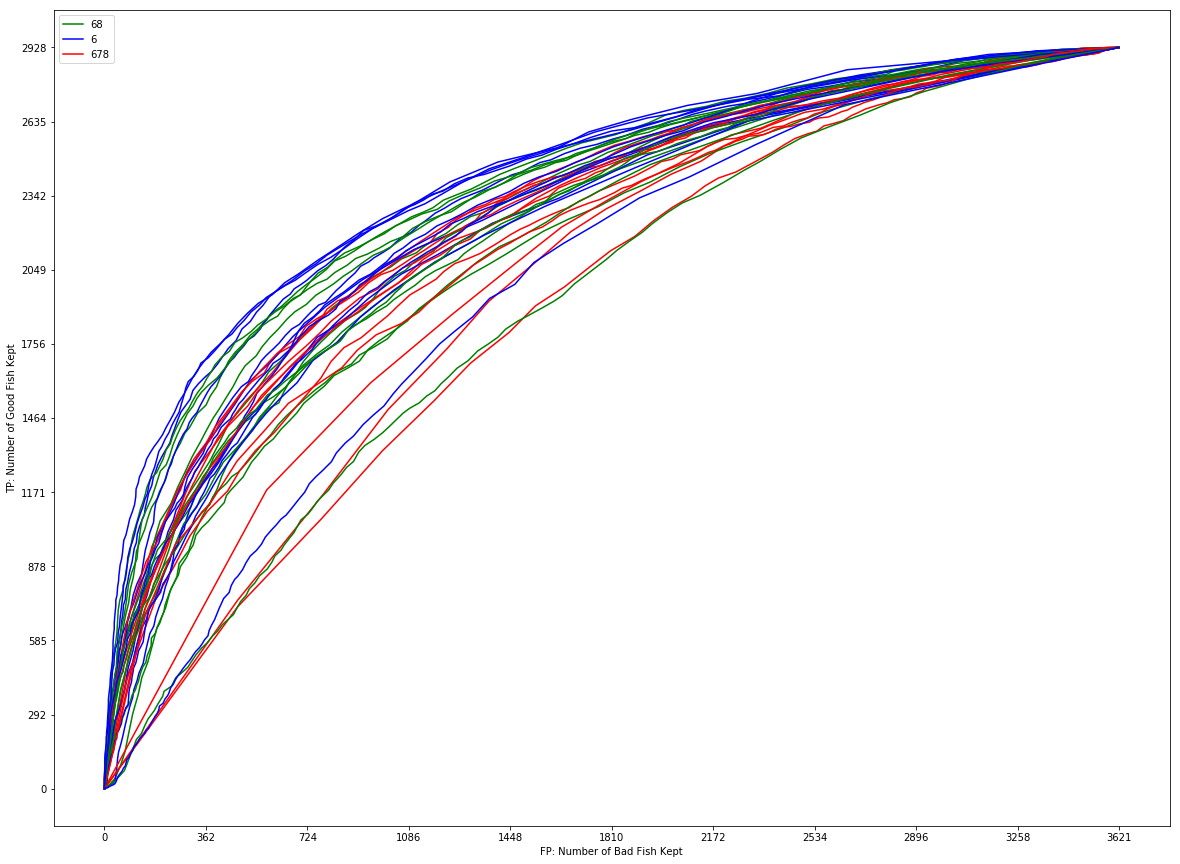

In [70]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(20,15))
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],c="b",alpha=1)
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],c="g",alpha=1)
    if i%3 == 0 and i != 0:
        plt.plot(roc[i,1,:],roc[i,0,:],c="r",alpha=1)
    
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
#ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class used: [6,7,8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:1",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Other classifiers"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3621).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 2928).astype(int))
plt.legend(["68","6","678"])

plt.show()

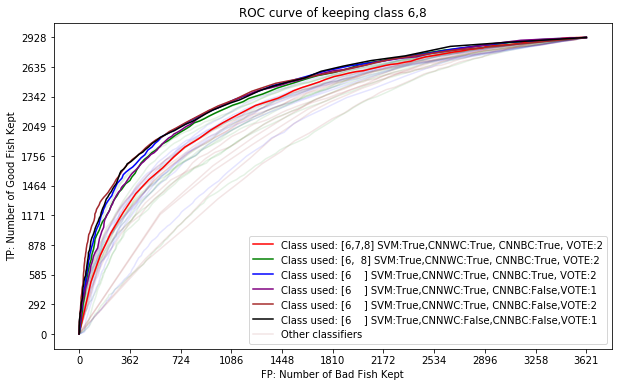

In [47]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(10,6))
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],c="b",alpha=0.1)
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],c="g",alpha=0.1)
    if i%3 == 0 and i != 0:
        plt.plot(roc[i,1,:],roc[i,0,:],c="darkred",alpha=0.1)
    
for i in range(36):
    if i == 0:
        m, = plt.plot(roc[i,1,:],roc[i,0,:],"darkred",alpha=0.1)
    
    if i == 1*3+0:
        a1, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 3*3+0:
#         a3, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 4*3+0:
#         a4, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 6*3+0:
#         a6, = plt.plot(roc[i,1,:],roc[i,0,:],"r")

    if i == 1*3+1:
        b1, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 3*3+1:
#         b3, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 4*3+1:
#         b4, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 7*3+1:
#         b7, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
    
    if i == 1*3+2:
        c1, = plt.plot(roc[i,1,:],roc[i,0,:],"blue")
    if i == 3*3+2:
        c3, = plt.plot(roc[i,1,:],roc[i,0,:],"purple")
    if i == 4*3+2:
        c4, = plt.plot(roc[i,1,:],roc[i,0,:],"brown")
    if i == 7*3+2:
        c7, = plt.plot(roc[i,1,:],roc[i,0,:],"black")
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class used: [6,7,8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:1",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Other classifiers"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3621).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 2928).astype(int))

plt.legend(np.arange(36))

plt.legend([a1,b1,c1,c3,c4,c7,m],titles)
plt.show()

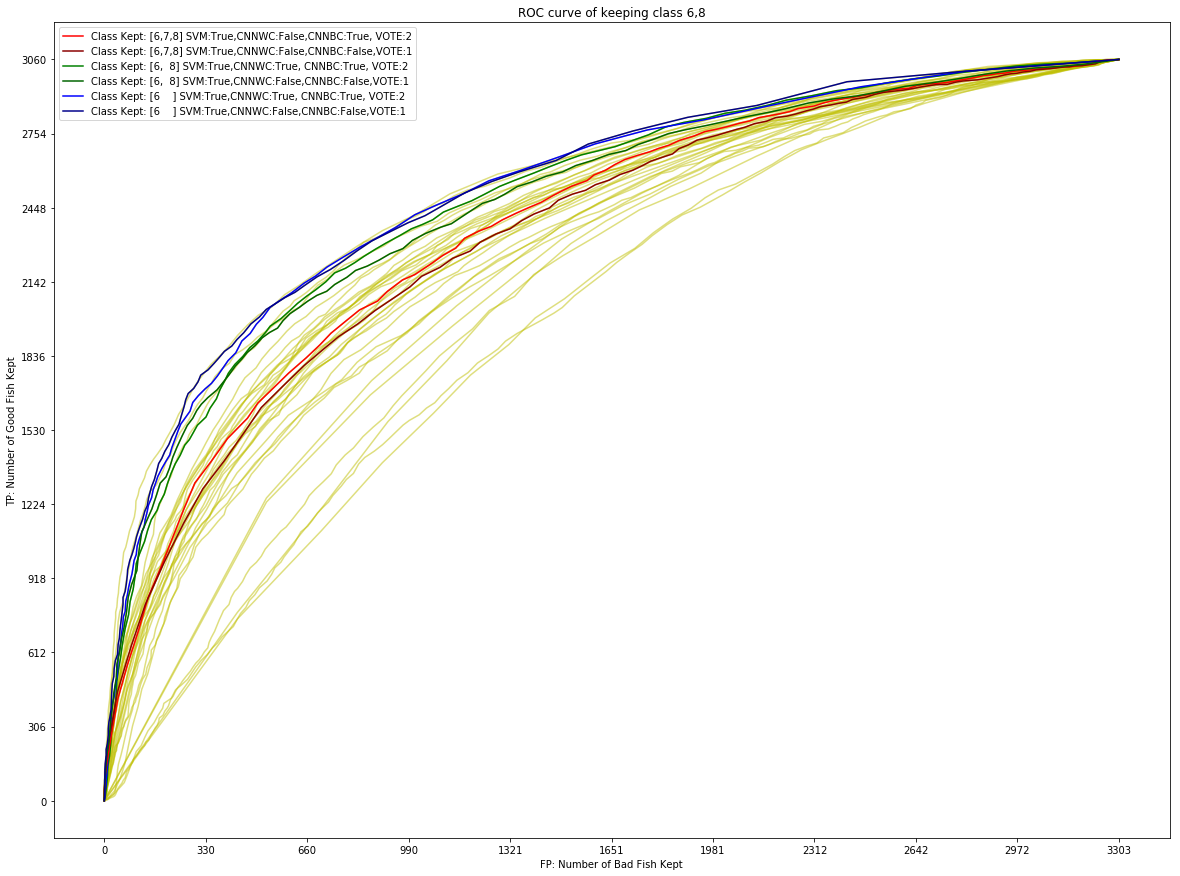

In [21]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(20,15))
for i in range(36):
    plt.plot(roc[i,1,:],roc[i,0,:],"y",alpha=0.5)
    
for i in range(36):
    if i == 6*3+0:
        a1, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
    if i == 7*3+0:
        a2, = plt.plot(roc[i,1,:],roc[i,0,:],"darkred")
        
    if i == 1*3+1:
        a3, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
    if i == 7*3+1:
        a4, = plt.plot(roc[i,1,:],roc[i,0,:],"darkgreen")
        
    if i == 1*3+2:
        a5, = plt.plot(roc[i,1,:],roc[i,0,:],"b")
    if i == 7*3+2:
        a6, = plt.plot(roc[i,1,:],roc[i,0,:],"darkblue")
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class Kept: [6,7,8] SVM:True,CNNWC:False,CNNBC:True, VOTE:2",
          "Class Kept: [6,7,8] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Class Kept: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class Kept: [6,  8] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Class Kept: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class Kept: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3303).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 3060).astype(int))

plt.legend([a1,a2,a3,a4,a5,a6],titles)
plt.show()

In [44]:
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0,keptRange=[6])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.01,keptRange=[6])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.01081,keptRange=[6])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.02,keptRange=[6])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.1,keptRange=[6])

Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 3060; Lost: 152 ;
None Fish Kept: 3303; Lost: 1440;
Accuracy: 0.565681961031
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 3009; Lost: 203 ;
None Fish Kept: 2779; Lost: 1964;
Accuracy: 0.62514142049
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 3005; Lost: 207 ;
None Fish Kept: 2750; Lost: 1993;
Accuracy: 0.628284098052
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2968; Lost: 244 ;
None Fish Kept: 2418; Lost: 2325;
Accuracy: 0.665367693275
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2509; Lost: 703 ;
None Fish Kept: 1173; Lost: 3570;
Accuracy: 0.764173475801


# Sample of FEIF fail

In [3]:
yhats, targets = getTrainingResult()

In [4]:
idl = np.array([396853,396857,396859,396860,396866,396876,396880,396892,396895,396900,
                    396823,396829,396843,396852,396862,396870,396882,396885,396889,396894,
                    396856,396863,396864,396868,396869,396893,396896,396897,396898,396899,
                    396624,396639,396662,396675,396728,396737,396759,396777,396790,396804,
                    396750,396760,396767,396784,396792,396793,396872,396877,396878,396886,
                    396824,396836,396839,396854,396858,396861,396865,396871,396874,396884,
                    396720,396733,396778,396815,396820,396827,396830,396834,396879,396890,
                    396840,396841,396845,396849,396850,396851,396867,396883,396887,396891,
                    396785,396802,396811,396822,396838,396844,396873,396875,396881,396888])
  
location = "/afs/inf.ed.ac.uk/group/project/F4KC/output/{0}/{1}/{2}.YHAT.npy"
start = True

for i in idl:
    idee = movs[i][0]
    length = movs_length[i]
    spacing = 1
    if length >= 200:
        spacing = length/100
    yhat = np.load(location.format(idee[0],idee[0:2],idee))
    gts = loadNewGT(idee, movs_length[i],True,spacing)
    gts = np.array(gts)
    mask = gts != None
    
    det = np.arange(len(yhat))[mask]
    
    yhat = yhat[mask]
    gts = gts[mask]
    vid = np.array([i]*len(gts))

    if start:
        yhats = yhat
        targets = gts
        vids = vid
        dets = det
        start = False
    else:
        yhats = np.vstack((yhats,yhat))
        targets = np.hstack((targets,gts))
        vids = np.hstack((vids,vid))
        dets = np.hstack((dets,det))

mask = targets != 0
yhats = yhats[mask]
targets = targets[mask]

#yhats = yhats.reshape(-1,40)
targets = targets.astype(int)

In [6]:
feif = np.sum(yhats,1)[:,6]>=3.999
class6 = targets == 6

fails = np.bitwise_and(feif,class6)

failsvideo = vids[fails]
failsdetection = dets[fails]

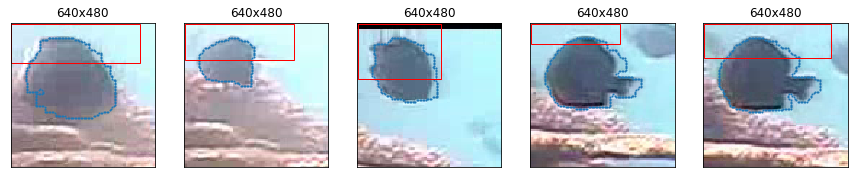

In [8]:
movs = loadMovids()
samp_vids = [343 ,638,6,5,13 ,146,408,153,408,5  ]
samp_fram = [1000,80 ,0,0,136,301,60 ,290,1  ,177]

plt.subplots(1,5,figsize=(15,3))

tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6

for i in np.arange(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if movs[failsvideo[i]][2] == "1":
        plt.title("640x480")
        large = True
    else:
        plt.title("320x240")
        large = False
        
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
    plt.imshow(clip[failsdetection[i]])
    cline = contour[failsdetection[i]]
    thisContour, cont2 = getContour(cline, return_what="Both")
    plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    
    x,y = np.min(cont2,0)
    if large and x <= 266 and y <= 33:
        plt.gca().add_patch(patches.Rectangle((0,0),266-x+10,33-y+10,fill=False,linewidth=1,color='red'))
        
    if (not large) and x <= 163 and y <= 16:
        plt.gca().add_patch(patches.Rectangle((0,0),163-x+10,16-y+10,fill=False,linewidth=1,color='red'))
        
    if x <= 6:
        plt.gca().add_patch(patches.Rectangle((0,0),6-x+10,100,fill=True,linewidth=1,color='red'))
    if y <= 0:
        plt.gca().add_patch(patches.Rectangle((0,0),100,0-y+10,fill=True,linewidth=1,color='red'))
plt.show()

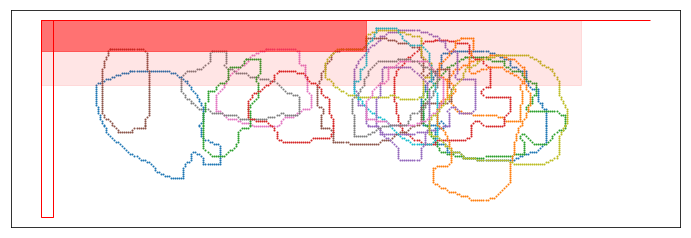

In [25]:
plt.figure(figsize=(12,4))
tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6
plt.gca().invert_yaxis()

#plt.gca().add_patch(patches.Rectangle((0,0),640,480,fill=False,linewidth=1,color='blue'))
plt.gca().add_patch(patches.Rectangle((0,0),266,33,fill=True,linewidth=1,color='red',alpha=0.1))
#plt.gca().add_patch(patches.Rectangle((6,0),626,478,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((0,0),160,16,fill=True,linewidth=1,color='red',alpha=0.5))
plt.gca().add_patch(patches.Rectangle((0,0),6,100,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((0,0),300,0,fill=True,linewidth=1,color='red'))

for i in np.arange(50):
    if movs[failsvideo[i]][2] == "1":
        
        info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
        cline = contour[failsdetection[i]]
        thisContour, cont2 = getContour(cline, return_what="Both")
        if min(cont2[:,0]) > 200:
            continue
        
        plt.scatter(cont2[:,0],cont2[:,1],s=1)
    
plt.xticks([])
plt.yticks([])
plt.show()

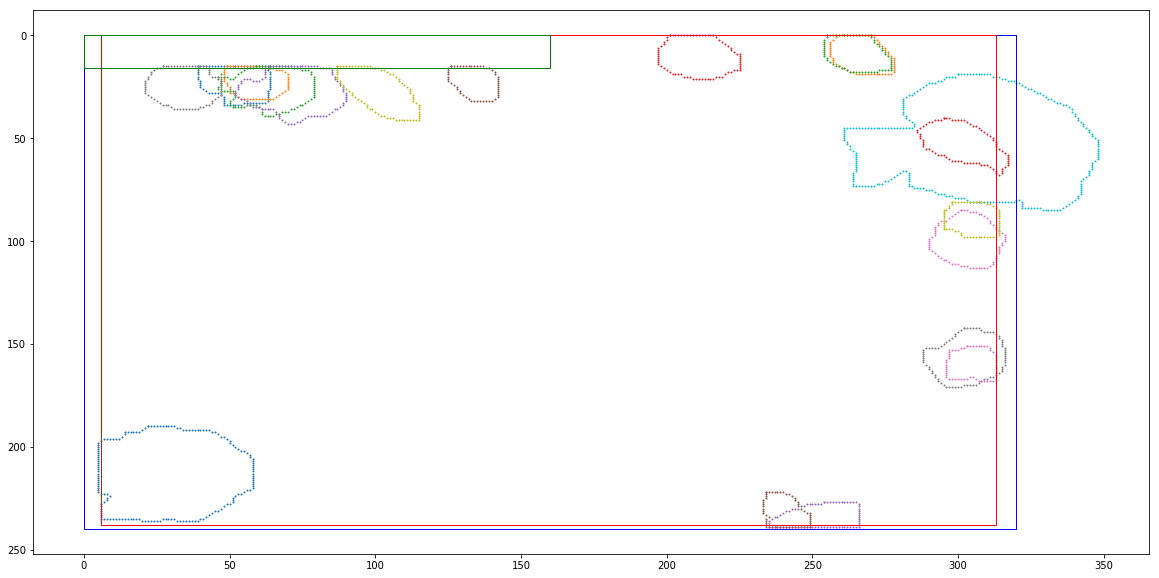

In [85]:
plt.figure(figsize=(20,10))
tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6
plt.gca().invert_yaxis()

plt.gca().add_patch(patches.Rectangle((0,0),320,240,fill=False,linewidth=1,color='blue'))
plt.gca().add_patch(patches.Rectangle((6,0),307,238,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((0,0),160,16,fill=False,linewidth=1,color='green'))

for i in np.arange(50):
    if movs[failsvideo[i]][2] == "0":
        
        info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
        cline = contour[failsdetection[i]]
        thisContour, cont2 = getContour(cline, return_what="Both")
        plt.scatter(cont2[:,0],cont2[:,1],s=1)
    
plt.show()

In [160]:
yhats, targets = getValidationResult()

In [149]:
yhats = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/yhat", 'rb'))
targets = np.array(pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/gts", 'rb')))

pick = np.arange(0,1000*1000,1000)
length = np.cumsum(movs_length)
mov_rand = np.array([0]*1000)
det_rand = np.array([0]*1000)
for i in range(1000):
    mov_rand[i] = np.argmin(length <= pick[i])
    det_rand[i] = pick[i] - np.sum(movs_length[:mov_rand[i]])
vids = mov_rand
dets = det_rand

In [164]:
l = len(targets)
binary = [False] * l

for i in range(l):
    binary[i] = getWeightedVote(yhats[i,0,:],keptRange=[6],lim=0.01081)

binary = np.bitwise_not(np.array(binary))
class6 = targets == 6
class8 = targets == 8
#notclass6 = targets != 6
feif = np.sum(yhats,1)[:,6]>=3.999
evr = np.sum(yhats,1)[:,1]>=3.999

fails = np.bitwise_and(binary,np.bitwise_or(class6,class8))
fails = np.bitwise_and(binary,class8)
fails = np.bitwise_and(fails,np.bitwise_not(feif))
fails = np.bitwise_and(fails,np.bitwise_not(evr))

failsvideo = vids[fails]
failsdetection = dets[fails]

In [165]:
print(movs[failsvideo])

[['fff9a68afb981078b637d7c1631150f2#201205071650' '37' '1']
 ['fffabc24d5931266c656a089b7d3bcd1#201205271510' '37' '1']
 ['fffd6a97a1d756d55dcb7e3631c33023#201108120810' '37' '0']
 ['fffd6a97a1d756d55dcb7e3631c33023#201108120810' '37' '0']
 ['ffff17255641d7182371793a39f7d1d4#201301091150' '37' '1']
 ['ffff17255641d7182371793a39f7d1d4#201301091150' '37' '1']
 ['ffff17255641d7182371793a39f7d1d4#201301091150' '37' '1']
 ['fffa6d41b1906bb0010829027da71d6d#201104300600' '38' '0']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#201304051630' '38' '1']
 ['fffbbc35313b7c9bd3a284699f9d4161#2013

In [152]:
plt.subplots(11,8,figsize=(16,16))
for i in range(88):
    plt.subplot(11,8,i+1)
    plt.hist(f[class6,i],color='red',alpha=0.2)
    plt.hist(f[notclass6,i],color='blue',alpha=0.2)
    
    for j in range(7955):
        if fails[j]:
            plt.axvline(x=f[j,i],alpha=0.2)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(i+1)
    plt.gca().title.set_position([.5, 0.92])
    
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7955 but corresponding boolean dimension is 1000

In [35]:
pca = pickle.load(open("/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/pcaObject",'rb'))

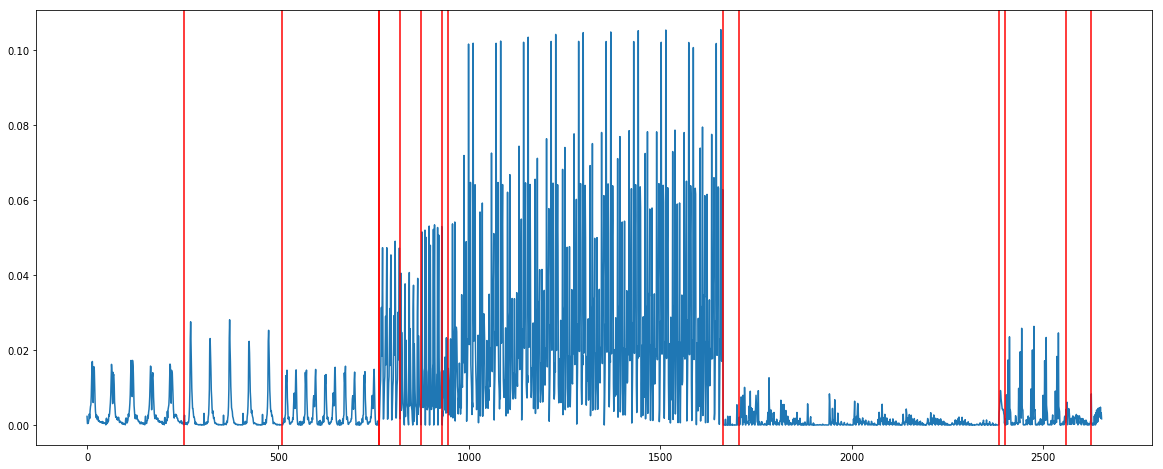

In [46]:
component = pca.components_
comp = np.abs(component[0])

plt.figure(figsize=(20,8))
plt.plot(comp)
plt.axvline(x=254.5,color="red")
plt.axvline(x=509.5,color="red")
plt.axvline(x=764.5,color="red")
plt.axvline(x=764.5,color="red")
plt.axvline(x=819.5,color="red")
plt.axvline(x=874.5,color="red")
plt.axvline(x=929.5,color="red")
plt.axvline(x=943.5,color="red")
plt.axvline(x=1663.5,color="red")
plt.axvline(x=1705.5,color="red")
plt.axvline(x=2385.5,color="red")
plt.axvline(x=2400.5,color="red")
plt.axvline(x=2560.5,color="red")
plt.axvline(x=2625.5,color="red")
plt.show()

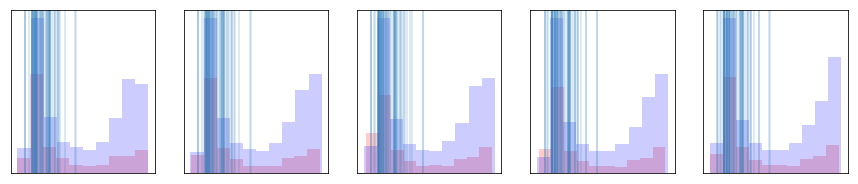

In [69]:
component = pca.components_
comp = np.abs(component[0])
maxs = comp.argsort()[-5:][::-1]
maxfs = np.dot(f,component[:100])[:,maxs]

plt.subplots(1,5,figsize=(15,3))

for i in np.arange(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
        
    plt.hist(maxfs[class6,i],color='red',alpha=0.2)
    plt.hist(maxfs[notclass6,i],color='blue',alpha=0.2)
    
    for j in range(7955):
        if fails[j]:
            plt.axvline(x=maxfs[j,i],alpha=0.2)
    
plt.show()

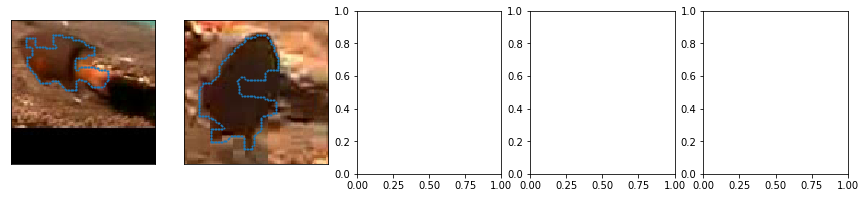

In [155]:
plt.subplots(1,5,figsize=(15,3))

for i in np.arange(0,2):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
        
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
    plt.imshow(clip[failsdetection[i]])
    cline = contour[failsdetection[i]]
    thisContour, cont2 = getContour(cline, return_what="Both")
    plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    
plt.show()

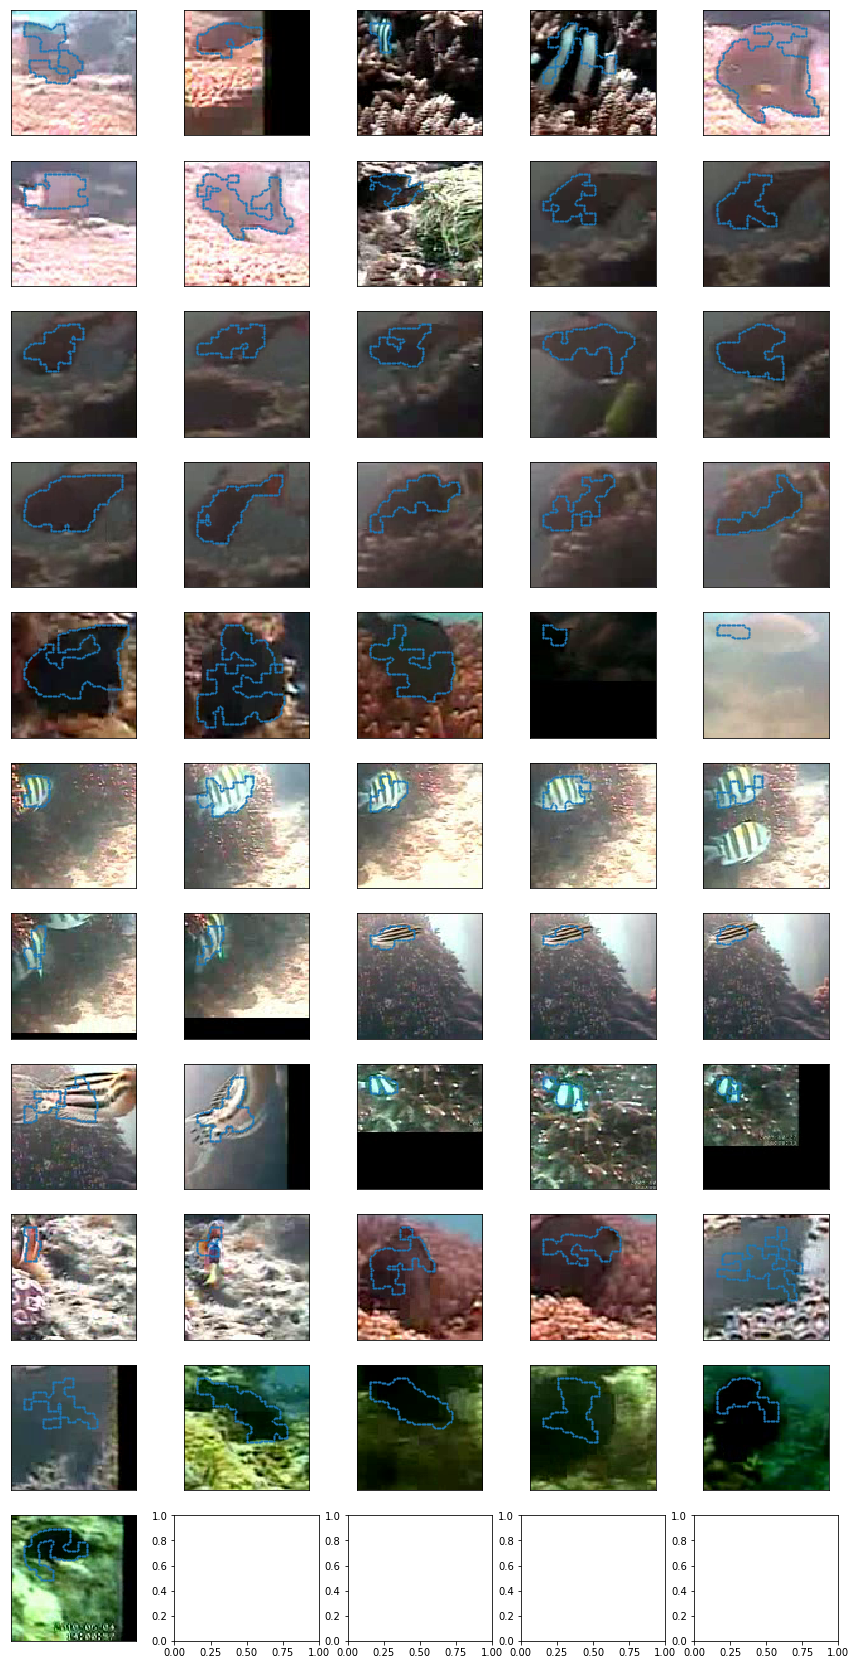

In [168]:
plt.subplots(11,5,figsize=(15,30))

for i in np.arange(0,51):
    plt.subplot(11,5,i+1)
    plt.xticks([])
    plt.yticks([])
        
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
    plt.imshow(clip[failsdetection[i]])
    cline = contour[failsdetection[i]]
    thisContour, cont2 = getContour(cline, return_what="Both")
    plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    
plt.show()

# RFC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

yhats, targets = getValidationResult(split=1)
yhats[yhats<0.4] = 0
rf = DecisionTreeClassifier().fit(yhats,targets)
#rf = RandomForestClassifier(n_estimators=100,n_jobs=4).fit(yhats,targets)
yhats2, targets2 = getValidationResult(split=2)
pred = rf.predict(yhats2)

cm = confusion_matrix(targets2,pred,labels=np.arange(1,11))
plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.heatmap(cm,xticklabels=np.arange(1,11), yticklabels=np.arange(1,11),annot=True,fmt='.0f')
plt.xlabel("RF Prediction")
plt.ylabel("True GT")
plt.subplot(122)
cm = cm*1.0/np.sum(cm,1).reshape(10,1)
sns.heatmap(cm,xticklabels=np.arange(1,11), yticklabels=np.arange(1,11),annot=True,fmt='.2f')
plt.xlabel("RF Prediction")
plt.ylabel("True GT")
plt.show()

In [ ]:
validateResult(pred,targets2,yrange=[6,8],grange=[6,8])

# FINAL VALIDATION COMPOSITION

In [73]:
pick = np.arange(0,1000*1000,1000)
length = np.cumsum(movs_length)
mov_rand = np.array([0]*1000)
det_rand = np.array([0]*1000)
for i in range(1000):
    mov_rand[i] = np.argmin(length <= pick[i])
    det_rand[i] = pick[i] - np.sum(movs_length[:mov_rand[i]])
    
info_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/info", 'rb'))
clip_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/clip", 'rb'))
hasContour_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/hasContour", 'rb'))
contour_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/contour", 'rb'))
yhat_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/yhat", 'rb'))
gts_rand = pickle.load(open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/gts", 'rb'))

In [110]:
info_rand = np.zeros((1000,4))
clip_rand = [None] * 1000
hasContour_rand = [True] * 1000 
contour_rand = [None] * 1000
yhat_rand = np.zeros((1000,4,10))

for i in range(1000):
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[mov_rand[i]])
    this = det_rand[i]
    print("{3}: {0} {1} {2}                ".format(mov_rand[i],this,frames,i),end='\r')
    info_rand[i,:] = info[this,:]
    clip_rand[i] = clip[this]
    contour_rand[i] = contour[this]
    yhat = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/output/0/00/{0}.YHAT.npy".format(movs[mov_rand[i]][0]))
    yhat_rand[i] = yhat[det_rand[i]]
    
#pickle.dump(info_rand,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/info", 'wb'))
#pickle.dump(clip_rand,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/clip", 'wb'))
#pickle.dump(hasContour_rand,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/hasContour", 'wb'))
#pickle.dump(contour_rand,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/contour", 'wb'))
#pickle.dump(yhat_rand,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/yhat", 'wb'))

gts = [None] * 1000
string = ""
with open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/super_duper_gt") as f:
    line = f.readlines()
    for l in line:
        string += l.strip()
for i in range(len(string)):
    gts[i] = int(string[i])
    if string[i] == "0": gts[i]=10
        
#pickle.dump(gts,open("/afs/inf.ed.ac.uk/group/project/F4KC/valid_rand/gts", 'wb'))

AttributeError: 'str' object has no attribute 'write'

In [32]:
isfault = np.array([False] * 1000)
#isfail = np.sum(yhat_rand,1)[:,6] > 3.99
isfail = np.array([False] * 1000)

for i in range(1000):
    mov = movs[mov_rand[i]]
    if int(mov[0][-12:-4]) > 20110805 and (int(mov[1])<= 39 or mov[1]=="42"): 
        isfault[i] = True
        
    c1,c2 = getContour(contour_rand[i],return_what="Both")
    feifpoint = np.sum(np.bitwise_and(c2[:,0]<266,c2[:,1]<33))
    if mov[2] == "1" and np.sum(np.bitwise_and(c2[:,0]<266,c2[:,1]<33)) > 40:
        isfail[i] = True

In [33]:
print(sum(isfault))
print(sum(isfail))
print(sum(np.bitwise_and(isfault,isfail)))

422
22
13


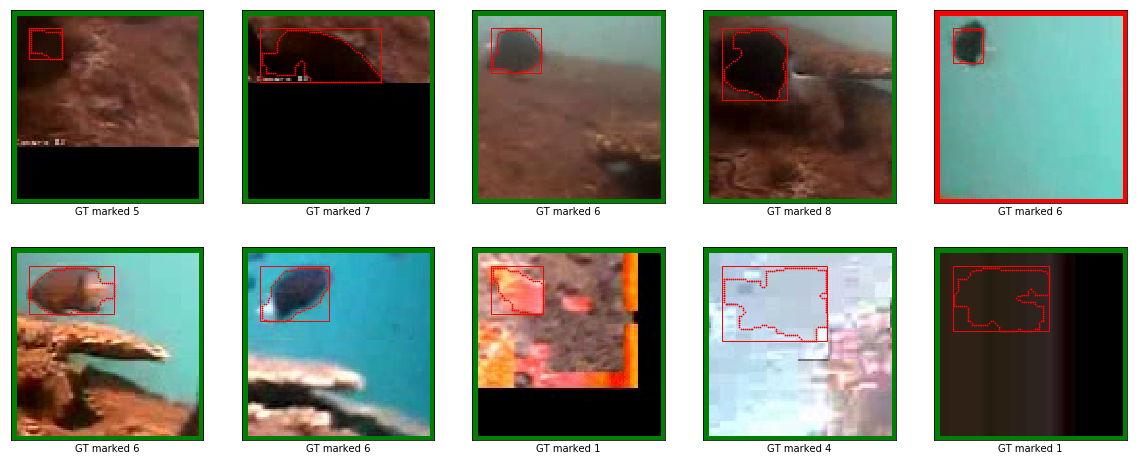

In [25]:
h = 0
w = 5
d = 2
g = 1
t = h + d * w

plotStuff(info, clip, hasContour, contour, movs[1],
          limit_lower=h, limit_upper=t, 
          width=w, gap=g, 
          classify=True, gt=gts_rand)

# final stat

In [102]:
def vote2(yhats,targets):
    
    svm=True
    cnn=False
    cnnwc=False
    cnnbc=False
    minvote=1
    keptRange=[6]
    lim=0.01081
    
    l = len(targets)
    #result = np.argmax(yhats,2) + 1
    
    binary = [False] * l
    summu = np.sum(yhats,1)[:,6]>=3.999
    summu2 = np.sum(yhats,1)[:,1]>=3.999
    
    print("Removed by Night Video: {0}".format(np.sum(summu2)))
    print("Removed by FEIF: {0}".format(np.sum(summu)))
    
    for i in range(l):
        #FEIF
        if summu[i] or summu2[i]:
            continue
            
        count = 0
        if svm   and getWeightedVote(yhats[i,0,:],keptRange=keptRange,lim=lim): count+=1
        if cnn   and getWeightedVote(yhats[i,1,:],keptRange=keptRange,lim=lim): count+=1
        if cnnwc and getWeightedVote(yhats[i,2,:],keptRange=keptRange,lim=lim): count+=1
        if cnnbc and getWeightedVote(yhats[i,3,:],keptRange=keptRange,lim=lim): count+=1
        if count >= minvote:
            binary[i] = True
    
    #Transform the result to fit old util
    fakeyhat = np.array([1] * l)
    fakeyhat[binary] = 6

    fakeyhat2 = np.array([1] * l)
    fakeyhat2[np.bitwise_not(summu)] = 6
    
    fakeyhat3 = np.array([1] * l)
    fakeyhat3[np.bitwise_not(summu2)] = 6
    
    fakeyhat4 = np.array([1] * l)
    fakeyhat4[np.bitwise_and(np.bitwise_not(summu),np.bitwise_not(summu2))] = 6
    
    print(validateResult(fakeyhat,targets,grange=[6,8],succint=True,value=True,ret=True))
    print(validateResult(fakeyhat2,targets,grange=[6,8],succint=True,value=True,ret=True))
    print(validateResult(fakeyhat3,targets,grange=[6,8],succint=True,value=True,ret=True))
    print(validateResult(fakeyhat4,targets,grange=[6,8],succint=True,value=True,ret=True))
    
    tp,fn,fp,tn = validateResult(fakeyhat,targets,grange=[6,8],succint=True,value=True,ret=True)

In [103]:
vote2(yhat_rand,gts_rand)

Removed by Night Video: 39
Removed by FEIF: 146
(373.0, 16.0, 339.0, 272.0)
(376.0, 13.0, 478.0, 133.0)
(388.0, 1.0, 573.0, 38.0)
(375.0, 14.0, 440.0, 171.0)


In [ ]:
New 1000 set:
                | rejected for plankton | rejected by FEIF | remaining rejected by SVM | remaining fish
True Fish       | 1                     | 13               | 2                         | 373
Bad or non-fish | 38                    | 133              | 101                       | 339

In [108]:
yhat, gts = getValidationResult()
vote2(yhat,gts)

Removed by Night Video: 327
Removed by FEIF: 1265
(3005.0, 207.0, 2750.0, 1993.0)
(3121.0, 91.0, 3569.0, 1174.0)
(3151.0, 61.0, 4477.0, 266.0)
(3060.0, 152.0, 3303.0, 1440.0)


In [ ]:
Validation set:
                | rejected for plankton | rejected by FEIF | remaining rejected by SVM | remaining fish
True Fish       | 61                    | 91               | 55                        | 3005
Bad or non-fish | 266                   | 1174             | 553                       | 2750

In [105]:
yhat, gts = getTrainingResult()
vote2(yhat,gts)

Removed by Night Video: 4813
Removed by FEIF: 11667
(26177.0, 4473.0, 19706.0, 20027.0)
(29560.0, 1090.0, 29156.0, 10577.0)
(27792.0, 2858.0, 37778.0, 1955.0)
(26702.0, 3948.0, 27201.0, 12532.0)


In [ ]:
Training set:
                | rejected for plankton | rejected by FEIF | remaining rejected by SVM | remaining fish
True Fish       | 2858                  | 1090             | 525                       | 26177
Bad or non-fish | 1955                  | 10577            | 7495                      | 19706